# 3-Information Transfer Calculation
## Mohammad Ghoraishi-99100788
---
(Code written as a group by Mohammad Ghoraishi-99100788 and Salarvandian-400100254)


Adding necessary libraries and packages. We will also use the OrdinalPatterns file which we created for the first exercise.

In [ ]:
include("./OrdinalPatterns.jl")
import .OrdinalPatterns as OP
using CSV, DataFrames, StatsBase, Plots, Plots.PlotMeasures, MAT, Dates
gr()

## Algorithm and Optimisations
---
This exercise requires alot of computation so using efficient algorithms is of great importance. <br>
1) Ordinal Pattern Calculation: <br>
    We calculate our ordinal patterns using the code we wrote for exercise one which was already fast. <br>
    We use the function ordinal_pattern_matrix() to calculate the ordinal patterns column-wise for each time-series.

2) Probability and Joint Probability Calculation:<br>
   For these calculations we use the fit(Histogram, arr) function from the StatsBase.jl package. <br>
   This function is fast by itself but we can make it faster by specifying the bin number as $d!$ <br>
   which eliminates the need to calculate the unique elements of the array. We can use this function for <br>
   one dimensional probability or multidimensional joint probabilities. 

3) Probability Values and Transfer Probability: <br>
   The transfer probabilities are calculated in the same way but one of the arrays of the joint probabilities<br>
   is shifted by the value $\delta$. functions P_x() and P_xy(), both use the methods discussed to calculate the <br>
   Probability density and methods P_xx_transfer() and P_xxy_transfer() both use the same method with a shifted <br>
   array to calculate the transfer joint probabilities.

4) Information Transfer Matrix Calculation: <br>
   Each value of the info-transfer matrix is calculated by the function T_yx() which uses the following formula:<br>
   $$
   T_{yx} = \sum P(x_{i + \delta}, x_i, y_i) \log \frac{P(x_{i + \delta}| x_i, y_i)}{P(x_{i + \delta}| x_i)}
   $$
   which the conditional probabilitiies are calculated using the formula:
   $$
   P(x|y) = \frac{P(x,y)}{P(y)}
   $$
   This function calculates the probabilites and sums over the nonzero ones throughout the entire space to give us $T_{yx}$. <br>
   The information_transfer_matrix() function calls the function above for every element of the matrix to generate the information transfer matrix.

5) Directionality Matrix Calculation: <br>
   We already have the information transfer matrix. so the calculation of the directionality matrix is as simple as calculating <br>
   the formula below for each element using said matrix. <br>
   $$
   D = \frac{T_{yx} - T_{xy}}{T_{yx} + T_{xy}}
   $$
   The function direction_matrix() does exactly this.
   

In [ ]:
#Function that calculates ordinal patterns column wise for a time-series matrix
function ordinal_pattern_matrix(mat, d)
    sizes = size(mat)
    newmat = zeros(Int, sizes[1], sizes[2])
    for i in 1:sizes[2]
        newmat[:,i] = OP.generate_ordinal_pattern(mat[:,i], d)
    end
    return newmat[d:end, :]
end

#1D version returns an array of probabilities which every element a, holds the probability for the number a to occur P(x_i) where x_i = a
function P_x(arr, d) 
   prob = fit(Histogram, arr, 1:1:factorial(d)+1)
   return prob.weights ./ sum(prob.weights)
end

#returns a 2D array of probabilities which every element a,b holds the probability P(x_i+delta, x_i) where x_i+delta = a and x_i = b
function P_xx_transfer(arr, d, delta) 
    prob = fit(Histogram, (arr[delta+1:end], arr[1:end-delta]), (1:1:factorial(d)+1,1:1:factorial(d)+1))
    return prob.weights ./ sum(prob.weights)
end

#2D version returns a 2D array of probabilities which every element a,b, holds the probability P(x_i,y_i) where x_i = a and y_i = b
function P_xy(arr_1, arr_2, d) 
    prob = fit(Histogram, (arr_1, arr_2), (1:1:factorial(d)+1,1:1:factorial(d)+1))
    return prob.weights ./ sum(prob.weights)
end

#3D version returns a 3D array of probabilities which every element a,b,c holds the probability P(x_i+delta,x_i,y_i) where x_i+delta = a, x_i = b and y_i = c
function P_xxy_transfer(arr_1, arr_2, d, delta) 
    prob = fit(Histogram, (arr_1[delta+1:end], arr_1[1:end-delta], arr_2[1:end-delta]), (1:1:factorial(d)+1,1:1:factorial(d)+1,1:1:factorial(d)+1))
    return prob.weights ./ sum(prob.weights)
end

#Function that calculates the information transfer between two time-series for a lag value delta. arr_1 corresponds to X and arr_2 corresponds to y
function T_yx(arr_1, arr_2, d, delta) 
    size = factorial(d)
    len = length(arr_1) - delta
    p_xxy_transfer = P_xxy_transfer(arr_1, arr_2, d, delta) #P(x_i+delta, x_i, y_i)
    p_xy = P_xy(arr_1, arr_2, d) #P(x_i, y_i)
    p_xx_transfer = P_xx_transfer(arr_1, d, delta) #P(x_i+delta, x_i)
    p_x = P_x(arr_1, d) #P(x_i)
    result = 0
    #Loop that goes through all combinations and adds them up to calculate T_yx
    for i in 1:size
        for j in 1:size
            for k in 1:size
                if (p_xxy_transfer[i,j,k] > 0 && p_xx_transfer[i,j] > 0 && p_xy[j,k] > 0 && p_x[j] > 0)
                    result += p_xxy_transfer[i,j,k] * 
                    log2(p_xxy_transfer[i,j,k] / (p_xx_transfer[i,j] * p_xy[j,k] / p_x[j])) #Conditional probabilities are calculated using the formula P(x|y) = P(x,y) / P(y)
                end
            end
        end
    end
    return result
end

#Function that takes the time-series data in matrix form, then generates a information transfer matrix of all possible combinations of time-series
function information_transfer_matrix(mat, d, delta)
    len, number = size(mat)
    T_matrix = zeros(number,number)
    for i in 1:number
        for j in 1:number
            if (i != j)
                T_matrix[i,j] = T_yx(mat[:,j], mat[:,i], d, delta) 
            end
        end
    end
    return T_matrix
end

#Function that takes the information transfer matrix and calculates the directionality matrix using the formula D_ij = (T_ji - T_ij) / (T_ji + T_ij)
function direction_matrix(T)
    w, h = size(T)
    D = zeros(w,w)
    for i in 1:w
        for j in 1:w
            if (T[i,j] != 0 && T[j,i] != 0)
                D[i,j] = (T[i,j] - T[j,i])/(T[i,j] + T[j,i])
            end
        end
    end
    return D
end

## Reading the Test data and calculating the ordinal patterns, then plotting the heatmap for information transfer and directionality
---
Using $d=3$ and $\delta = 1$

In [ ]:
d = 3
delta = 1
df = CSV.read("data/Ex3-test.txt", DataFrame, header = false) 
test_data = Matrix(select!(df, Not(1)))
ordinal_test_data = ordinal_pattern_matrix(test_data, d)

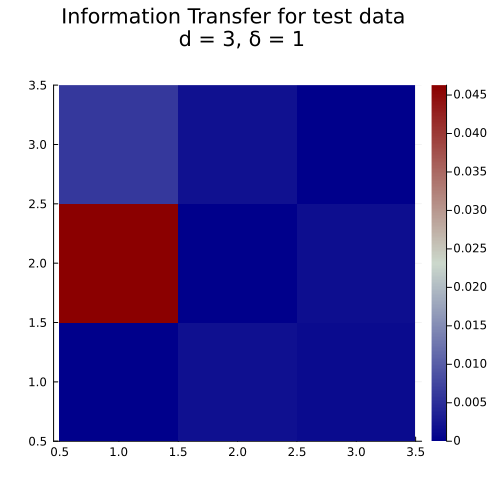

In [115]:
info_mat = information_transfer_matrix(ordinal_test_data, d, delta)
heatmap(info_mat, aspectratio = 1, c = :bluesreds, size = (500,500), title = "Information Transfer for test data \n d = $d, δ = $delta", left_margin = 5mm, right_margin = 5mm)

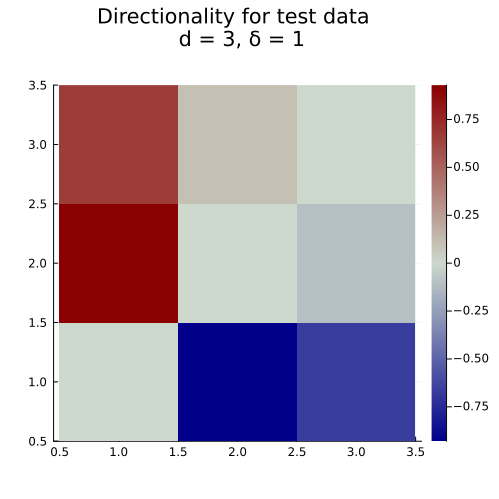

In [116]:
dir_mat = direction_matrix(info_mat)
heatmap(dir_mat, aspectratio = 1, c = :bluesreds, size = (500,500), title = "Directionality for test data \n d = $d, δ = $delta", left_margin = 5mm, right_margin = 5mm)

Result Analysis: <br>
In the information transfer matrix we can clearly see that in this data, timeseries 1 is <br>
influencing timeseries 2 but not vice-versa which indicates information transfer. In the <br>
Directionality heatmap we can also see the direction of the flow.

### using higher d and $\delta$:
$d = 6$, $\delta = 5$

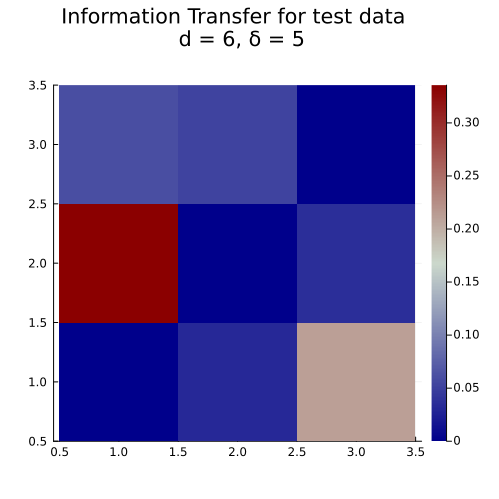

In [117]:
d = 6
delta = 5
df = CSV.read("data/Ex3-test.txt", DataFrame, header = false) 
test_data = Matrix(select!(df, Not(1)))
ordinal_test_data = ordinal_pattern_matrix(test_data, d)
info_mat = information_transfer_matrix(ordinal_test_data, d, delta)
heatmap(info_mat, aspectratio = 1, c = :bluesreds, size = (500,500), title = "Information Transfer for test data \n d = $d, δ = $delta", left_margin = 5mm, right_margin = 5mm)

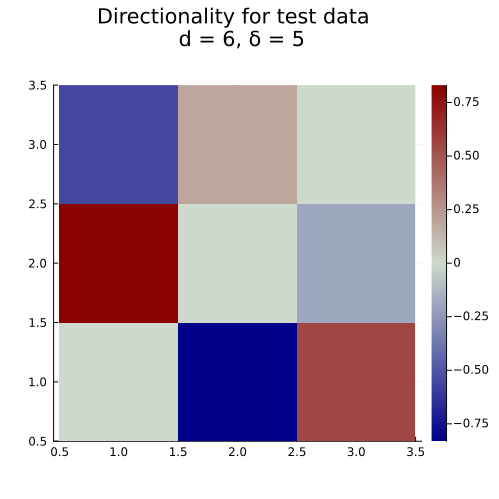

In [118]:
dir_mat = direction_matrix(info_mat)
heatmap(dir_mat, aspectratio = 1, c = :bluesreds, size = (500,500), title = "Directionality for test data \n d = $d, δ = $delta", left_margin = 5mm, right_margin = 5mm)

Result analysis:<br>
we can see that changes can occur by changing $d$ and especially $\delta$. <br>
The change in lag time has caused new information transfers to emerge, but <br>
the relations previously computed are mostly still there too. 

## Doing the same thing for S&P500 data
---
$d = 3$ , $\delta = 1$ (Without local normalization) <br>
the method for openning the S&P data is the same as the previous exercise

In [ ]:
function return_rate_matrix(mat::Matrix)
    height, width = size(mat)
    new_mat = zeros(height-1, width) #The resulting matrix has one less row than the original
    #Main loop iterates over the matrix and calculates the return rate, then writes the result directly to the new matrix
    for i in 1:height-1 
        for j in 1:width
            new_mat[i,j] = (mat[i+1,j] - mat[i,j])/mat[i,j]
        end
    end
    return new_mat
end

d = 3
delta = 1
file = matopen("data/sxp/price/All.mat") #We use the MAT.jl package to extract the matrix from the file
a = read(file)
matrix = a["A"]
#Calculating the return rate for the matrix and normalizing it for k=13
matrix = return_rate_matrix(matrix)
ordinal_SP = ordinal_pattern_matrix(matrix, d)

A run of the entire S&P data, for $d=3$ and $\delta=1$ takes only 12 seconds.

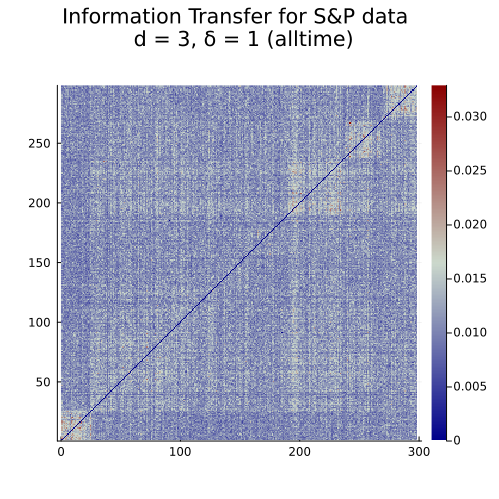

In [125]:
info_mat = information_transfer_matrix(ordinal_SP, d, delta)
heatmap(info_mat, aspectratio = 1, c = :bluesreds, size = (500,500), title = "Information Transfer for S&P data \n d = $d, δ = $delta (alltime)", left_margin = 5mm, right_margin = 5mm)

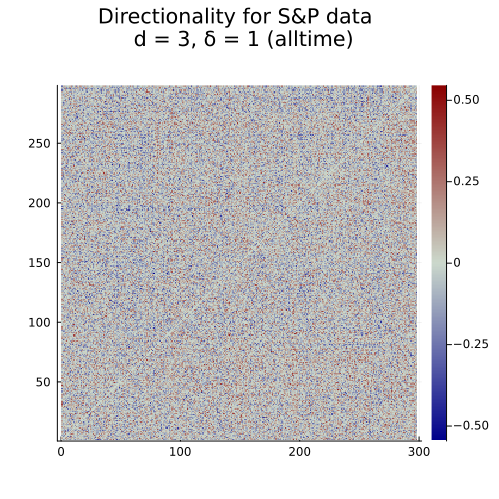

In [126]:
dir_mat = direction_matrix(info_mat)
heatmap(dir_mat, aspectratio = 1, c = :bluesreds, size = (500,500), title = "Directionality for S&P data \n d = $d, δ = $delta (alltime)", left_margin = 5mm, right_margin = 5mm)

Result Analysis: <br>
We can see that for alltime data, the information and directionality patterns, <br>
are really noisy even though some hotspots exist. In the following sections we will <br>
see that smaller windows are better suited for this kind of analysis.

### Calculating the Directionality matrix for different values of $\delta$ (as a gif)
---

In [ ]:
anim = @animate for i in 1:20
    info_mat = information_transfer_matrix(ordinal_SP, d, i)
    dir_mat = direction_matrix(info_mat)
    heatmap(dir_mat, aspectratio = 1, c = :bluesreds, size = (500,500), title = "Directionality for S&P data \n d = $d, δ = $i (alltime)", left_margin = 5mm, right_margin = 5mm)
end
gif(anim, "directionality_variable_delta.gif", fps = 5)

Gif is included in the compressed file as directionality_variable_delta.gif. <br> <br>
Result Analysis: <br>
We can see the patterns change quite alot with change in delta which means different lags hold different directionalities. <br>
This means some markets ifluence other quicker while some take a bit of time. By significant increase in lag however we will <br>
see chaos.

### Calculating the directionality matrix for two month windows (as a gif)
---
$d = 3$ and $\delta = 1$ <br>
The method used for the dates is the same as the previous exercise

In [138]:
#Calculating all Directionality matrices
d = 3
delta = 1
Date_array = CSV.read("data/sxp/price/Date.csv", DataFrame)[!,1][12:end] #Openning the dates data and removing the first 12 entries to account for normalization
index = 1
matrix_array = [] #array to save all matrices
df_dates = DataFrame(start_date = Date_array[index], end_date = Date_array[index+42]) #dataframe to keep track of dates for each matrix
while (Date_array[index] + Week(8) <= Date_array[end]) #We continue the loop until there aren't 8 weeks worth of continous data
    end_index = findfirst(x -> (x >= Date_array[index] + Week(8)), Date_array) #Calculating the first index where 8 weeks has passed
    mat = information_transfer_matrix(ordinal_SP[index:end_index, :], d, delta) #Calculating the information information_transfer matrix in the correct timeframe
    mat = direction_matrix(mat)
    #Saving the results in arrays
    push!(matrix_array, mat)
    push!(df_dates, [Date_array[index] Date_array[end_index]])
    index = end_index + 1
end

In [ ]:
anim = @animate for num in 1:length(matrix_array) #Animation loop
    start = df_dates.start_date[num]
        ends = df_dates.end_date[num]
        heatmap(matrix_array[num], aspectratio = 1, c = :bluesreds, size = (400,400), title = "Directionality matrix for S&P data \n d = 3, δ = 1 \n$start - $ends",
            xticks = ([13; 36; 70; 112; 144; 174; 215; 254; 272; 287], ["E"; "M"; "I"; "CD"; "CS"; "H"; "F"; "IT"; "C"; "U"]),
            yticks = ([13; 36; 70; 112; 144; 174; 215; 254; 272; 287], ["E"; "M"; "I"; "CD"; "CS"; "H"; "F"; "IT"; "C"; "U"]))
end
gif(anim, "directionality_variable_timeframe.gif", fps = 12)

(The gif is included in the files as directionality_variable_timeframe.gif) <br>
<br>
Result Analysis: <br>
We can see that the pattern changes drastically over time and in each time-scale there are multiple transfers between markets.<br>
These patterns even if they are more chaotic than the correlation matrices previously calculated, they seem more useful.